In [74]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns


In [75]:
# Define the grid environment
grid_size = 10
grid = np.zeros((grid_size, grid_size))  # The grid
terminal_states = [(0, 0), (grid_size - 1, grid_size - 1)]  # Terminal states

# Define rewards for each state (positive for terminal states)
goal_state = (grid_size - 1, grid_size - 1)
rewards = np.full((grid_size, grid_size), -1)  # Reward of -1 for each step
rewards[0, 0] = 0
#rewards[grid_size - 1, grid_size - 1] = 0

#obstacle = [(8,7), (8,8), (8,9)]
obstacle = [(3,3), (4,3), (5,3), (6,3), (6,4), (6,5), (6,6), (6,7), (5,7), (4,7), (8,9), (8,8), (8,7), (8,1), (8,2), (9,1), (9,2)]
for i in obstacle:
    rewards[i] = -10
    
rewards[goal_state] = 20.0  # Positive reward for reaching the goal
#rewards[obstacle] = -10.0  # Large negative reward for hitting the obstacle


In [76]:
# Define possible movements based on actions
actions = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1)
}

In [77]:
# Define the initial policy (random actions)
policy = {}
# Initialize the policy randomly for non-terminal states
for i in range(grid_size):
    for j in range(grid_size):
        if (i, j) not in terminal_states and (i, j) not in obstacle:  # Avoid terminal and obstacle states
            policy[(i, j)] = random.choice(list(actions.keys()))  # Choose a random action
# Initialize state-value function arbitrarily
state_values = np.zeros((grid_size, grid_size))

In [78]:
# Helper function to get the next state after taking an action
def get_next_state(state, action):
    action_delta = actions[action]  # Convert action string to coordinate change
    next_state = (state[0] + action_delta[0], state[1] + action_delta[1])
    
    # Ensure the next state is within bounds and not an obstacle
    if (0 <= next_state[0] < grid_size) and (0 <= next_state[1] < grid_size):
        if next_state not in obstacle:  # If it's not the obstacle, move
            return next_state
    
    # If next_state is an obstacle or out of bounds, return the current state
    return state

In [79]:
def monte_carlo_policy_evaluation(episodes, gamma=1.0, max_steps=100):
    returns = {}  # Dictionary to store returns for each state
    for i in range(grid_size):
        for j in range(grid_size):
            returns[(i, j)] = []  # Initialize empty list of returns for each state

    for _ in range(episodes):
        # Generate an episode
        state = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
        episode = []
        steps = 0
        visited_states = set()  # Keep track of visited states
        G = 0  # Initialize return
        
        while state not in terminal_states and state not in obstacle and steps < max_steps:
            action = policy[state]
            next_state = get_next_state(state, action)
            reward = rewards[next_state]
            
            episode.append((state, reward))
            state = next_state
            steps += 1
        
        # Compute returns and update state values
        for t in range(len(episode)-1, -1, -1):  # Backward pass through the episode
            state, reward = episode[t]
            G = gamma * G + reward
            
            # First-visit Monte Carlo
            if state not in visited_states:
                visited_states.add(state)
                returns[state].append(G)
                state_values[state] = np.mean(returns[state])  # Update state value with average return


In [80]:
def plot_state_value_convergence(value_tracking, episodes):
    plt.figure(figsize=(10, 5))
    
    for i in range(grid_size):
        for j in range(grid_size):
            state_values_over_time = [values[i, j] for values in value_tracking]
            plt.plot(episodes, state_values_over_time, label=f'State ({i}, {j})')

    plt.xlabel('Episodes')
    plt.ylabel('State Value')
    plt.title('State Value Convergence Over Episodes')
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [81]:
# Monte Carlo Policy Iteration
def monte_carlo_policy_iteration(episodes, gamma=1.0, tracking_interval=2):
    state_value_tracking = []  # To store state values at intervals
    tracking_episodes = []
    for ep in range(episodes):
        monte_carlo_policy_evaluation(episodes, gamma)
        for i in range(grid_size):
            for j in range(grid_size):
                state = (i, j)
                if state not in terminal_states and state not in obstacle:
                    # Greedy policy improvement based on state values
                    action_returns = {}
                    for action in actions:
                        next_state = get_next_state(state, action)
                        action_returns[action] = rewards[next_state] + gamma * state_values[next_state]
                    policy[state] = max(action_returns, key=action_returns.get)

        # Track state values every 'tracking_interval' episodes
        if ep % tracking_interval == 0:
            state_value_tracking.append(state_values.copy())
            tracking_episodes.append(ep)

    # Plotting the convergence of state values for a specific state (for example, (0, 2))
    plot_state_value_convergence(state_value_tracking, tracking_episodes)


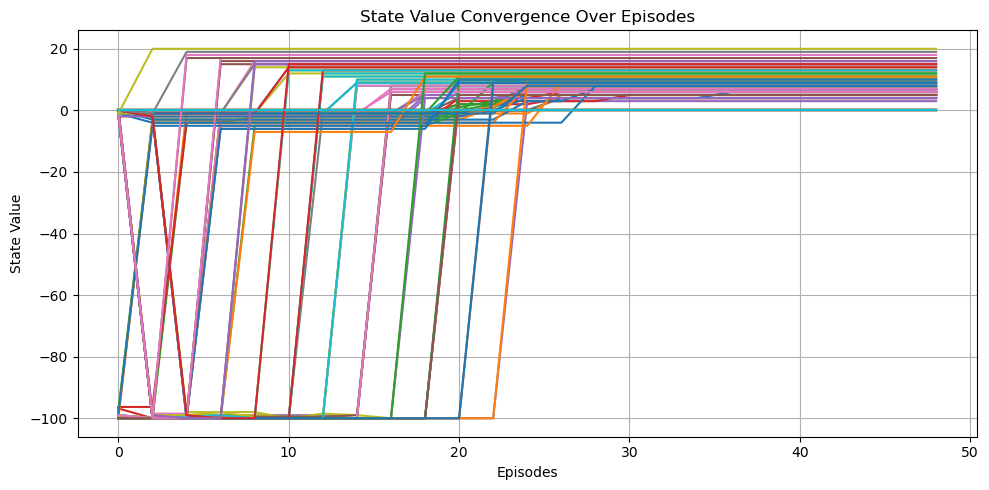

In [82]:
# Run Monte Carlo Policy Iteration
monte_carlo_policy_iteration(50, tracking_interval=2)

Final State Values:
[[ 0.  4.  5.  4.  3.  4.  5.  6.  7.  6.]
 [ 4.  5.  6.  5.  4.  5.  6.  7.  8.  7.]
 [ 5.  6.  7.  6.  5.  6.  7.  8.  9.  8.]
 [ 6.  7.  8.  0.  6.  7.  8.  9. 10.  9.]
 [ 7.  8.  9.  0.  5.  6.  7.  0. 11. 10.]
 [ 8.  9. 10.  0.  4.  5.  6.  0. 12. 11.]
 [ 9. 10. 11.  0.  0.  0.  0.  0. 13. 12.]
 [10. 11. 12. 13. 14. 15. 16. 15. 14. 13.]
 [ 9.  0.  0. 14. 15. 16. 17.  0.  0.  0.]
 [ 8.  0.  0. 15. 16. 17. 18. 19. 20.  0.]]
Final Policy:


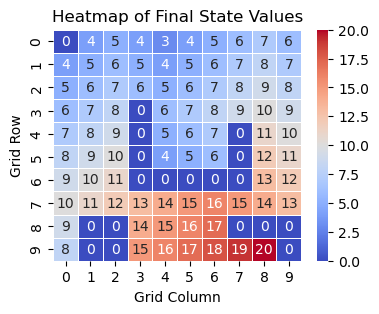

State (0,0): No policy assigned
State (0,1): down
State (0,2): down
State (0,3): down
State (0,4): down
State (0,5): down
State (0,6): down
State (0,7): down
State (0,8): down
State (0,9): down
State (1,0): down
State (1,1): down
State (1,2): down
State (1,3): down
State (1,4): down
State (1,5): down
State (1,6): down
State (1,7): down
State (1,8): down
State (1,9): down
State (2,0): down
State (2,1): down
State (2,2): down
State (2,3): left
State (2,4): down
State (2,5): down
State (2,6): down
State (2,7): down
State (2,8): down
State (2,9): down
State (3,0): down
State (3,1): down
State (3,2): down
State (3,3): obstacle
State (3,4): right
State (3,5): right
State (3,6): right
State (3,7): right
State (3,8): down
State (3,9): down
State (4,0): down
State (4,1): down
State (4,2): down
State (4,3): obstacle
State (4,4): up
State (4,5): up
State (4,6): up
State (4,7): obstacle
State (4,8): down
State (4,9): down
State (5,0): down
State (5,1): down
State (5,2): down
State (5,3): obstacle


In [83]:
# Print final results
print("Final State Values:")
print(state_values)
print("Final Policy:")

# Heatmap of state values
plt.figure(figsize=(4,3))
sns.heatmap(state_values, annot=True, cmap="coolwarm", cbar=True, linewidths=.5)
plt.title("Heatmap of Final State Values")
plt.xlabel("Grid Column")
plt.ylabel("Grid Row")
plt.show()

for i in range(grid_size):
    for j in range(grid_size):
        if (i, j) not in obstacle:  # Skip obstacle
            if (i, j) in policy:
                print(f"State ({i},{j}):", policy[(i, j)])
            else:
                print(f"State ({i},{j}): No policy assigned")
        else:
            print(f"State ({i},{j}): obstacle")